In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jul 30 07:29:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install transformers

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re
from google.colab import runtime

In [6]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data"
tsvData = os.path.join(dataDir,"WoSDataset_5736.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(5736, 4)


In [7]:
print(tsvData[0:15])

[['2' 'biochemistry'
  ' candidatus phytoplasma    16s rrna biosecurity taxonomy biodiversity vector seed transmission host range       '
  'phytoplasmas are insectvectored bacteria that cause disease in a wide range of plant species the increasing availability of molecular dna analyses expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasmaplant host associations and in the numbers of taxonomic groupings for phytoplasmas the widespread use of common names based on the diseases with which they are associated as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16s rrnaencoding gene complicates interpretation of the literature we explore this issue and related trends through a focus on australian pathosystems providing the first comprehensive compilation of information for this continent covering the phytoplasmas host plants vectors and diseases of the 33 16sr groups reported internati

In [8]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [9]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1292 1597 2847]


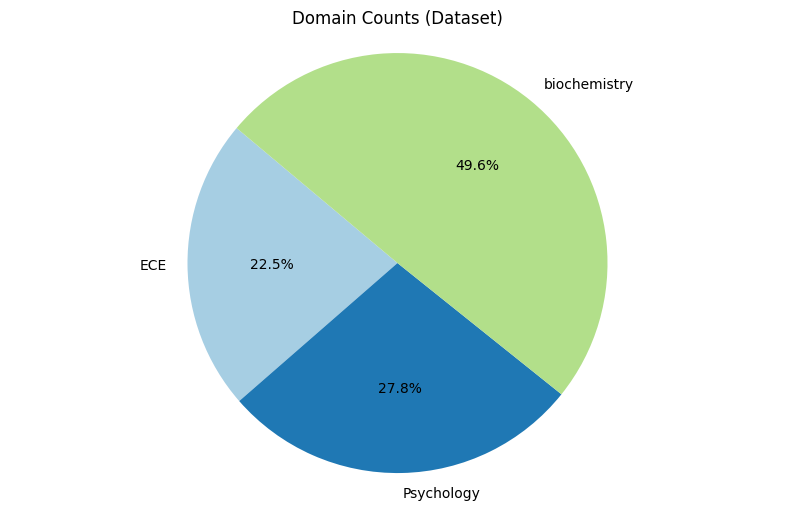

The domain ECE has 1292 records in the dataset.
The domain Psychology has 1597 records in the dataset.
The domain biochemistry has 2847 records in the dataset.


In [10]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [11]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  5736
Shape of abstracts:  (5736,)
['food restriction affects the activation of the immune system although the metabolic cost associated with mounting such a response has rarely been examined except in model animals wild animals are constantly exposed to variations in the availability of food resources and they need to balance their energy budget to fight against pathogens we examined the effect of food restriction in the fish eating myotis myotis vivesi a species of bat that experiences periods in which foraging is limited due to ambient conditions we tested the hypothesis that acute food restriction similar to 65 restriction for 1 night would reduce the caloric response to lipopolysaccharidae lps injection compared to bats fed ad libitum we also measured a proxy for body temperature tskin and expected reduced fever development when food intake was limited bats on the restricted diet had similar resting metabolic rate total caloric cost and tskin after the lps cha

In [12]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16")

(4588, 4)
(1148, 4)
(4588, 4)
(1148, 4)
(230, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [13]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  4588
Shape of abstracts:  (4588,)
Number of keywords:  4588
Shape of keywords:  (4588,)
Number of domains:  4588
Shape of domains:  (4588,)
Number of labels:  4588
Shape of labels:  (4588,)
['chloroplast development is regulated by many biological processes however these processes are not fully understood leaf variegation mutants have been used as powerful models to elucidate the genetic network of chloroplast development since the degree of leaf variegation is regulated by developmental and environmental cues the thylakoid formation 1 thf1 mutant is unique for its variegation in both leaves and cotyledons here we reported a new suppressor gene of thf1 leaf variegation designated sot8 mapbased cloning and dna sequencing results showed that a single nucleotide mutation from g to a was detected in the second exon of the gene encoding the ribosomal protein small subunit 9 prps9 in sot81 resulting in an amino acid change and a partial loss of prps9 function however so

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1028 1283 2277]


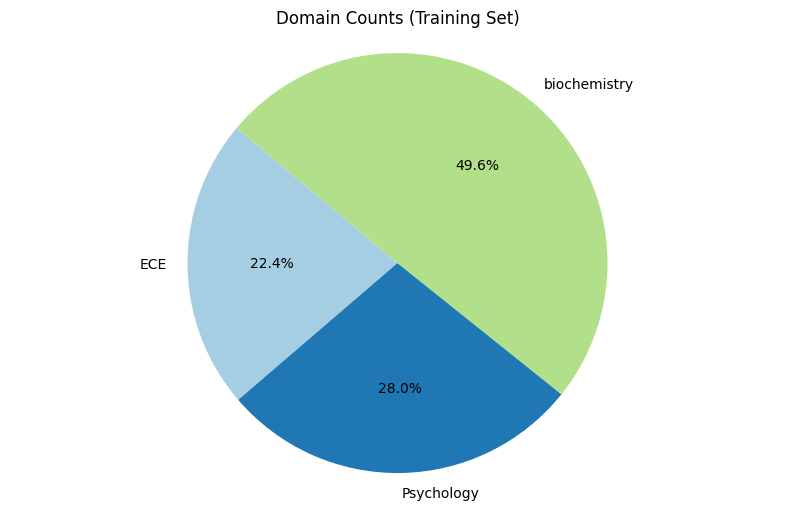

The domain ECE has 1028 records in the training set.
The domain Psychology has 1283 records in the training set.
The domain biochemistry has 2277 records in the training set.


In [14]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [15]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  1148
Shape of abstracts:  (1148,)
Number of keywords:  1148
Shape of keywords:  (1148,)
Number of domains:  1148
Shape of domains:  (1148,)
Number of labels:  1148
Shape of labels:  (1148,)
['in crustaceans the fascinating processes of maturation reproductive molting and carapace coloration are regulated by hydrophobic molecules interestingly most of the molecules are ligands of lipocalin to understand the role of lipocalin in the aforementioned processes at molecular level we isolated a cdna that belongs to the lipocalin family from a central nervous system cdna library of macrobrachium rosenbergii we monitored the spatial and temporal distributions of the mrna by using northern blotting analysis our results demonstrated that this gene expresses abundantly in the subepidermal adipose tissue while faintly in the hepatopancreas and central nervous system however no signal was detected in other tissues including muscle gill and ovary its expression levels in subepid

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [264 314 570]


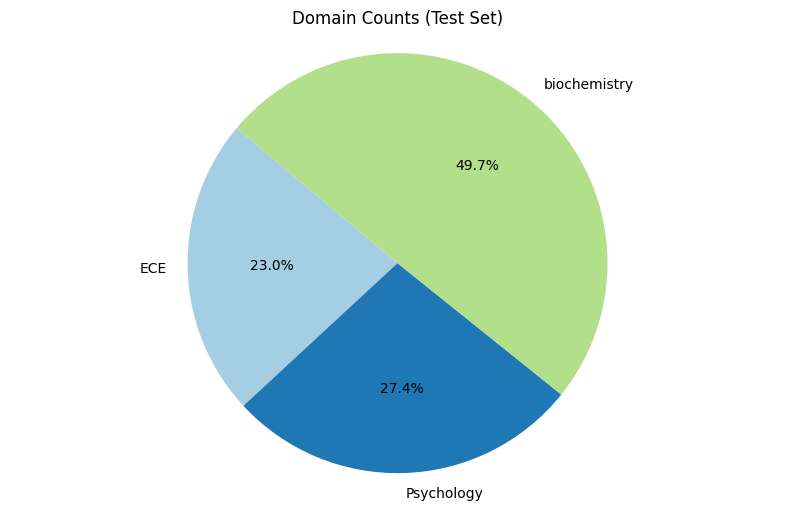

The domain ECE has 264 records in the test set.
The domain Psychology has 314 records in the test set.
The domain biochemistry has 570 records in the test set.


In [16]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [17]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  230
Shape of abstracts:  (230,)
Number of keywords:  230
Shape of keywords:  (230,)
Number of domains:  230
Shape of domains:  (230,)
Number of labels:  230
Shape of labels:  (230,)
['natural killer cells nk cells are traditionally attributed to the innate immune system it is considered that previously received stimuli have little effect on the functioning of these immune cells indeed nk cells even without prior sensitization provide a rapid effector response against tumor virusinfected or otherwise damaged cells they have a limited repertoire of receptors the expression of which does not require somatic recombination however recent data indicate that nk cells may acquire the properties specific to adaptive immune cells in particular nk cells have been shown to possess the features of immunological memory namely the ability to more quickly and effectively respond to a repeated stimulus the mechanisms of memory acquisition in nk cells differ from those implemented 

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [ 53  58 119]


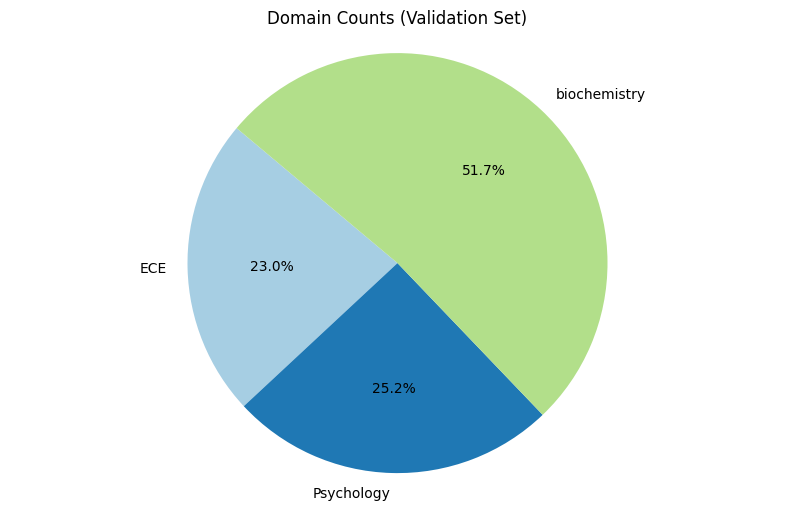

The domain ECE has 53 records in the vaidation set.
The domain Psychology has 58 records in the vaidation set.
The domain biochemistry has 119 records in the vaidation set.


In [18]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [19]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstract
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [20]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(4588, 4)
(1148, 4)
(230, 4)


In [21]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  4588
Label length  230
Label length  1148


In [22]:
print(np.unique(train_data[:,0]))

['0' '1' '2']


In [23]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

3


pytorch_model.bin:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [24]:
model.config

BertConfig {
  "_name_or_path": "bionlp/bluebert_pubmed_uncased_L-24_H-1024_A-16",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [25]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [27]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 1/20
  Train Loss: 0.43337495278360116
  Val Micro F1: 0.9521739130434783
  Time: 5m 1s


Epoch 2/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 2/20
  Train Loss: 0.1576906293242549
  Val Micro F1: 0.9521739130434783
  Time: 5m 1s


Epoch 3/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 3/20
  Train Loss: 0.10296344173548277
  Val Micro F1: 0.9739130434782609
  Time: 5m 1s


Epoch 4/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 4/20
  Train Loss: 0.04917443045350309
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 5/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 5/20
  Train Loss: 0.022226302629860584
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 6/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 6/20
  Train Loss: 0.013193172685633827
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 7/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 7/20
  Train Loss: 0.005262771629329816
  Val Micro F1: 0.9782608695652174
  Time: 5m 1s


Epoch 8/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 8/20
  Train Loss: 0.0019444729181890984
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 9/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 9/20
  Train Loss: 0.002109602057417861
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 10/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 10/20
  Train Loss: 0.000130377598755634
  Val Micro F1: 0.9826086956521739
  Time: 5m 1s


Epoch 11/20: 100%|██████████| 144/144 [04:55<00:00,  2.06s/batch]


Epoch 11/20
  Train Loss: 0.004186643171679962
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 12/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 12/20
  Train Loss: 8.580424969295564e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 13/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 13/20
  Train Loss: 7.605728569615167e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 14/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 14/20
  Train Loss: 6.753717275387316e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 15/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 15/20
  Train Loss: 5.928821110501303e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 16/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 16/20
  Train Loss: 0.0016083918442038542
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 17/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 17/20
  Train Loss: 5.2494904113902725e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 18/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 18/20
  Train Loss: 4.914233795716427e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 19/20: 100%|██████████| 144/144 [04:56<00:00,  2.06s/batch]


Epoch 19/20
  Train Loss: 4.775930824507668e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


Epoch 20/20: 100%|██████████| 144/144 [04:55<00:00,  2.06s/batch]


Epoch 20/20
  Train Loss: 4.643182801879043e-05
  Val Micro F1: 0.9869565217391304
  Time: 5m 1s


In [28]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[253   7   4]
 [  7 295  12]
 [  0   4 566]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       264
           1       0.96      0.94      0.95       314
           2       0.97      0.99      0.98       570

    accuracy                           0.97      1148
   macro avg       0.97      0.96      0.97      1148
weighted avg       0.97      0.97      0.97      1148

Macro F1 Score: 0.966633549025509
Micro F1 Score: 0.9703832752613241
Weighted F1 Score: 0.9702455714194194
Macro Precision: 0.9698792672413048
Micro Precision: 0.9703832752613241
Weighted Precision: 0.9703263265680989
Macro Recall: 0.9636020784445188
Micro Recall: 0.9703832752613241
Weighted Recall: 0.9703832752613241


In [29]:
model.save_pretrained('/content/drive/MyDrive/WoS/BlueBERT_WoS_Abstracts_5736')

In [ ]:
runtime.unassign()